In [17]:
import os
from pathlib import Path
home = os.getcwd()
current = home
while 'data' not in os.listdir(current):
    current = Path(current).parent
DATA_FOLDER = os.path.join(current, 'data')
PREPARED_DATA_FOLDER = os.path.join(current, 'prepared_data')

In [18]:
# let's try to understand which products bring the most profit
import pandas as pd
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
import numpy as np
products_count = order_items.groupby('product_id')['price'].agg(['count']).sort_values('count', ascending=False).reset_index().reset_index()
# products_count.head()
orders = pd.merge(left=order_items, right=products_count, on='product_id', how='inner').sort_values('count', ascending=False)

In [20]:
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index,count
44648,657c1689361cce2eeaabea76ced5e30f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-12-21 02:12:21,75.0,13.08,0,527
78215,b20541ce2d6f4c7d3b204035f09ea681,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-09 04:30:36,69.9,12.43,0,527
72419,a52c52c656d3b3ef3ec72fcdc13c714f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-04-26 12:31:56,69.9,0.00,0,527
75915,acdb814f2758bfa4cf10c3ce5cb09c81,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-03-12 22:48:55,69.9,21.57,0,527
68781,9d241238f3827aced623154ace551dd9,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-03-16 03:48:52,69.9,12.43,0,527


In [21]:
top_products = orders[orders['index'] < 50]
top_products[top_products['index'] == 49]['count'].min(), top_products[top_products['index'] == 48]['count'].min()

(111, 113)

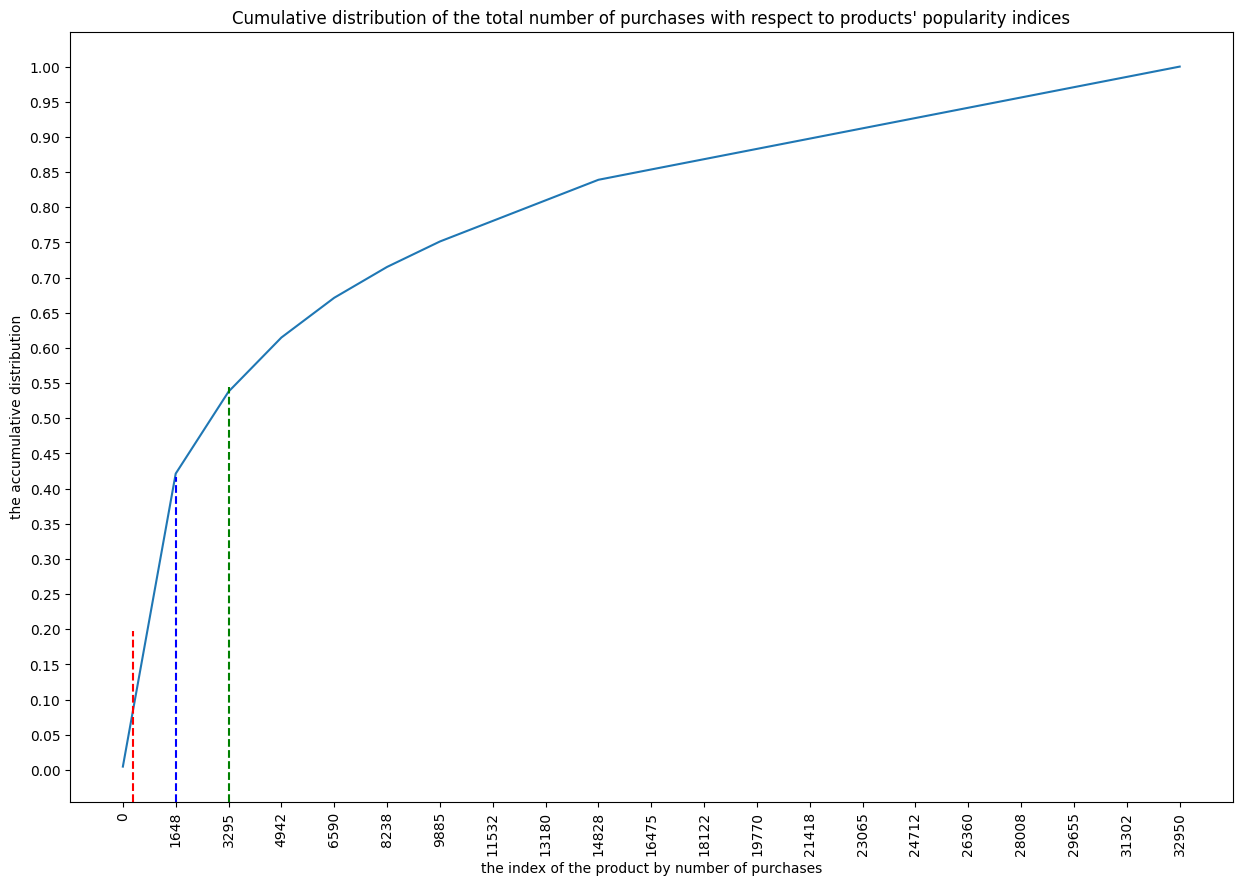

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
# let's build a smart cdf
from statsmodels.distributions.empirical_distribution import ECDF as smart_cdf
x = orders['index']
emperical_cdf = smart_cdf(x)

# let's take a look at this 
sample = np.linspace(0, x.max(), 21)
plt.plot(sample, emperical_cdf(sample))

# let's consider the top 1% , 5% and 10% of the products respectively
qx = np.quantile(np.unique(x), [0.01, 0.05, 0.1]) 
qy = emperical_cdf([int(x) for x in qx])

# let's plot them
for x, y, q, color in zip(qx, qy, [0.01, 0.05, 0.1], ['r', 'b', 'g']):
    plt.axvline(x, ymax=y, color='c', label=f'{100 * q}-th quantile', c=color, linestyle='--')

plt.xticks(sample, rotation=90)
plt.yticks(np.linspace(0, 1, 21))
plt.title("Cumulative distribution of the total number of purchases with respect to products' popularity indices")
plt.ylabel('the accumulative distribution')
plt.xlabel('the index of the product by number of purchases')
plt.show()


As we can see the 1% most popular products occupy around 20% of the market share and the top $5\%$ occupy around 40%

In [23]:
top_products = orders[orders['index'] <= qx[0]]
len(top_products)

24916

# Number of pictures and product popularity ?
Can we find enough statistical evidence to determine the significance of image quality and the length of the description on the popularity of the product ?

In [24]:
# let's see how things go !!
products = pd.read_csv(os.path.join(DATA_FOLDER, 'olist_products_dataset.csv'))
df = products.copy()
df.drop(columns=["product_length_cm", "product_height_cm", "product_width_cm"], inplace=True)
ps = top_products.groupby('product_id')['price'].agg(['count']).sort_values(by='count', ascending=False)
pdf = pd.merge(left=df, right=ps, how='inner', on='product_id')
pdf.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,count
0,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,38.0,1176.0,3.0,15350.0,63
1,bbaef2eadf31fe3ea6702077398be06c,perfumaria,45.0,1003.0,2.0,400.0,65
2,c6336fa91fbd87c359e44f5dca5a90ed,esporte_lazer,39.0,772.0,1.0,150.0,94
3,593236d0ff46b4299b4787fb8d43f7f0,industria_comercio_e_negocios,44.0,1396.0,2.0,7225.0,37
4,386486367c1f9d4f587a8864ccb6902b,cama_mesa_banho,54.0,120.0,1.0,835.0,55


In [25]:
# let's try to understand which characteristics affect the product the most: number of photos, description length ? 
pdf['product_photos_qty'].value_counts()
# let's see if the number of photos make a difference 
pdf['multi_photo'] = (pdf['product_photos_qty'] > 1).astype(int)
p0, p1 = pdf[pdf['multi_photo'] == 0], pdf[pdf['multi_photo'] == 1]

In [29]:
len(p0), len(p1)

(178, 152)

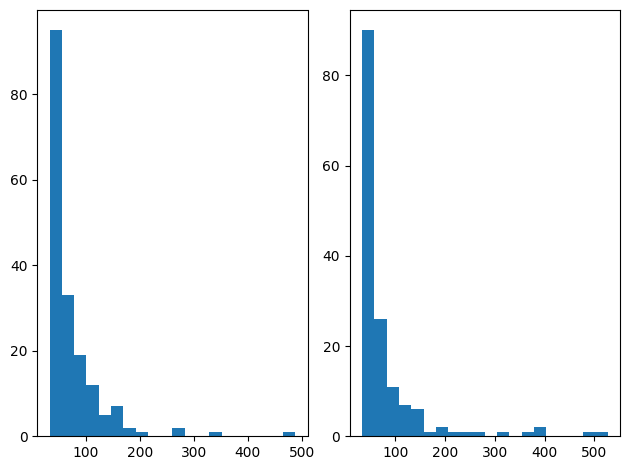

In [26]:
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(p0['count'], bins=20)
axs[1].hist(p1['count'], bins=20)

plt.show()

In [ ]:
# TODO: # explain that the distributions are not normal (it is pretty obvious through the visualization above, however, it would be valuable to perform a statistical test
# to confirm this claim), thus, we cannot apply t-test as it assumes normality of the data
# on the other hand

In [28]:
# can we see the problem now ?
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(p0['count'].values, p1['count'].values)
print(p)

0.27948963740210664


In [ ]:
# we can also apply the large interval test:

with a p-value quite large; $\approx 0.28 > > > 0.05$, then we can safely conclude that there is no significant difference in popularity between products with only 1 picture and those with multiple pictures. 

Sellers might probably need to focus on better descriptions for their products at this point...

# Products and their Description lengths

Although the length by itself is definitely not enough to fully analyze the effect of description on products, but it is currently the best information at our disposal

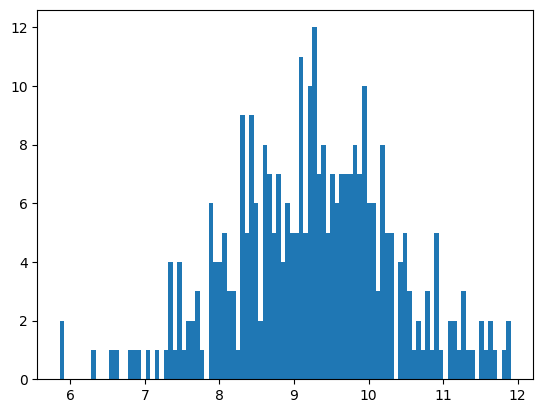

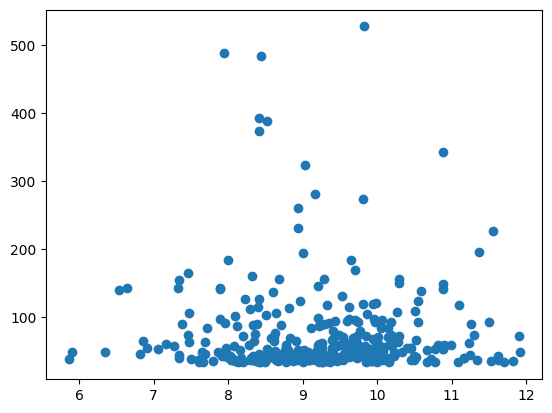

In [36]:
x = pdf['product_description_lenght']
log_x = np.log2(x)
plt.hist(log_x, bins=100, density=False)
plt.show()
y = pdf['count']
plt.scatter(log_x, y)
plt.show()

In [ ]:
# TODO: learn about regression analyzis to analysis the relationship between 2 continous variables...